**pySpark Basics: GLM and Data Preparation**

*by Jeff Levy (jlevy@urban.org)*

Last Updated: 29 Aug 2016, Spark v2.0

_**Abstract**: We will explore preparing your data for analysis in pySpark, in particular configuring the independent variables.  Then we will test it on the GLM function and show how to view the results._

**_Main operations used:_** *Pipeline, StringIndexer, OneHotEncoder, VectorAssembler, GeneralizedLinearRegression, fit, build_indep_vars, summarizer*

***

To look at pySpark's GLM capabilities, we will use the simplest example of a gausian error distribution with an identity link function, which is equivalent to OLS.  In our model we'll try to answer a simple question: how does a change in size (carat) affect a dimaond's price when we control for clarity?  We will test the equation:

    price = a + B*carat + clarity_dummy_vars + e
    
Don't worry about the accuracy of this model specification, or the assumptions behind it; our goal is just to compare pySpark's GLM function to something most users will be more familiar with.  

# Stata Output

Here are the results from Stata, which we can use for comparison because the diamonds dataset we're using for testing isn't actually that large.  Note that `clarity` has to be converted to numeric because Stata can't work with strings - this is also true of pySpark.  In Stata this was done using:

    encode clarity, gen(clarity_)
    
Using the `i.` prefix on a column name in the regression command makes Stata split a categorical column out into dummy variables.

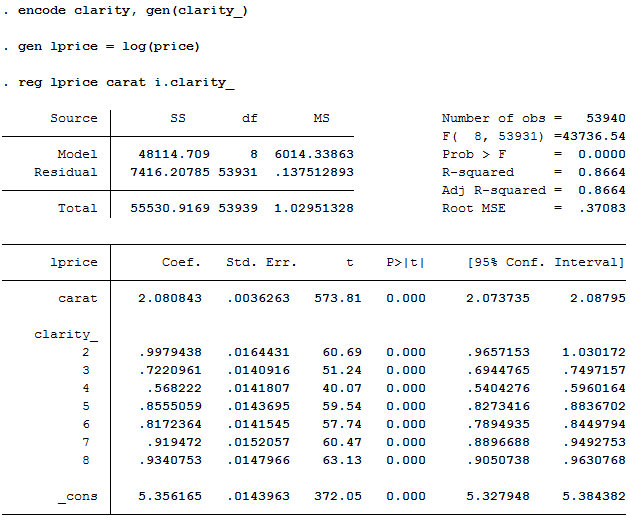

In [8]:
#Here we just use Jupyter's tools to import an image of the Stata output
from IPython.display import Image
Image(filename='stata_reg.PNG')

# pySpark ML Library

Next we will compare the Stata output for this simple model to what we can do in pySpark using their ML library, short for Machine Learning.  The nature of distributed computing makes solving models like this more complicated than most researchers are used to: if your data is distributed across 100 computers and there's no possible way it can all be loaded in one place *how do you invert a matrix?*

There is more than one approch to parameter estimation to address this, but the one used by pySpark 2.0 is called **L-BFGS**, which stands for Limited Memory Broyden–Fletcher–Goldfarb–Shanno.  Explaining how it works is beyond the scope of this simple tutorial, but suffice to say it's an algorithm designed to accomplish parameter estimation in a memory-efficient way that our distributed system can handle.

# Configuring Independent Variables

Before we run the analysis, we must first set up our data for ML to work with.  pySpark ML analysis tools, such as GLM or OLS, require a particular formatting of the independent variables. The tools they offer for this are powerful and flexible, but require the use of an excessive amount of obscure-looking code to accomplish what most social scientists will be used to achieving in one or two simple lines of Stata or SAS code.

The standard formatting **requires exactly two columns** from a dataframe: *a dependent variable column* usually referred to as 'label', and *an independent variable column* usually referred to as 'features'. The dependent variable is simply a column of numerical data; the column for the independent variables must be a *sparse vector*.  

*Optional explanation: A sparse vector is a memory-efficient version of a normal vector where, instead of filling in every zero, zero values are automatically filled in during calculation for any missing entries - this makes it more efficient the more zeroes there are in your independent variables.  A model that includes dummy variables is therefore ideal.*

In order to skip over a lot of this tedious code, I've written a wrapper that handles it all behind the scenes for you:

In [9]:
"""
Code copied and pasted from:

    https://github.com/UrbanInstitute/pyspark-tutorials/blob/master/indep_vars/build_indep_vars.py
    
Then deleted from view for display purposes.
""";

This function, `build_indep_vars`, takes in as arguments a pySpark dataframe, a list of column names for the independent variables, and an optional list of any independent variables that are categorical.  It then handles in the background getting the data in the proper format and expanding the categorical variable columns into multiple columns of dummy variables.  When completed it returns the original dataframe with a new column added to it named 'indep_vars' that contains the properly formatted vector.

It has an additional `summarizer` argument, which defaults to `True`.  This causes `build_indep_vars` to return two things: the modified dataframe and a "summarizer" object that knows some things about the data, and has the ability to create a more nicely-formatted summary output (which pySpark does not have natively).

Let's demonstrate on some data:

In [10]:
df = spark.read.csv('s3://ui-spark-social-science-public/data/diamonds.csv', inferSchema=True, header=True, sep=',')

We'll trim the dataset to only the columns we're interested in, just for convenience, and add a column for the logged dependent variable:

In [11]:
df = df[['carat', 'clarity', 'price']]

from pyspark.sql.functions import log
df = df.withColumn('lprice', log('price'))

In [12]:
df.show(5)

+-----+-------+-----+------------------+
|carat|clarity|price|            lprice|
+-----+-------+-----+------------------+
| 0.23|    SI2|  326| 5.786897381366708|
| 0.21|    SI1|  326| 5.786897381366708|
| 0.23|    VS1|  327|5.7899601708972535|
| 0.29|    VS2|  334| 5.811140992976701|
| 0.31|    SI2|  335| 5.814130531825066|
+-----+-------+-----+------------------+
only showing top 5 rows



Then we call the `build_indep_vars` function discussed above.  The only arguments that *have* to be passed in are the first two; the dataframe and the columns that are independent variables.  All the others are left in here just for explanatory purposes.

If you specify anything for `categorical_vars=[...]`, those columns must also be in the independent variables argument.  If you change `keep_intermediate=True`, the modified dataframe will include two extra columns per categorical variable that were intermediate steps to get to the final result.  And if you change `summarizer=False` then you'll need to change the assignment at the beginning to be only `df = build_indep_vars(...)` instead of `df, summarizer = build_indep_vars(...)`, because it will only return the modified dataframe.

In [13]:
df, summarizer = build_indep_vars(df, 
                                  ['carat', 'clarity'], 
                                  categorical_vars=['clarity'], 
                                  keep_intermediate=False, 
                                  summarizer=True)

In [14]:
df.show(5)

+-----+-------+-----+------------------+--------------------+
|carat|clarity|price|            lprice|          indep_vars|
+-----+-------+-----+------------------+--------------------+
| 0.23|    SI2|  326| 5.786897381366708|(8,[0,3],[0.23,1.0])|
| 0.21|    SI1|  326| 5.786897381366708|(8,[0,1],[0.21,1.0])|
| 0.23|    VS1|  327|5.7899601708972535|(8,[0,4],[0.23,1.0])|
| 0.29|    VS2|  334| 5.811140992976701|(8,[0,2],[0.29,1.0])|
| 0.31|    SI2|  335| 5.814130531825066|(8,[0,3],[0.31,1.0])|
+-----+-------+-----+------------------+--------------------+
only showing top 5 rows



We'll skip any more explanation of the contents of the `indep_vars` column, other than to note that it contains all the information necessary for the calculation of the right hand side of our equation.  

# Running GLM

We can now move on to analysis.  There are two steps to this: First a structure is specified for the GLM equation.  Note once again that we specify the names of the columns that have our **dependent and independent** variables using the common machine learning terms, **label and features**.  Then we fit that GLM equation to our data to get a model.  Most types of analysis in pySpark follow this general format.

We will test it using a stanard gaussian distribution with an identity link function, making it equivalent to OLS.  From the pySpark ML documentation, other supported distributions and link functions are:

    “gaussian” -> “identity”, “log”, “inverse”
    “binomial” -> “logit”, “probit”, “cloglog”
    “poisson” -> “log”, “identity”, “sqrt”
    “gamma” -> “inverse”, “identity”, “log”

In [15]:
from pyspark.ml.regression import GeneralizedLinearRegression

glm = GeneralizedLinearRegression(family='gaussian', 
                                  link='identity', 
                                  labelCol='lprice', 
                                  featuresCol='indep_vars', 
                                  fitIntercept=True)

model = glm.fit(df)

We can query the results directly from the model, without using the `summarizer` that the `build_indep_vars` function generated:

In [16]:
model.coefficients

DenseVector([2.0808, 0.7221, 0.8172, 0.5682, 0.8555, 0.9341, 0.9195, 0.9979])

In [17]:
model.intercept

5.356165273724909

In [18]:
model.summary.tValues

[573.8145328923426,
 51.24311447314843,
 57.736801306869914,
 40.069982524765486,
 59.53629044537795,
 63.12762399645197,
 60.46906625364304,
 60.69082330168219,
 372.05231564539275]

In [19]:
model.summary.coefficientStandardErrors

[0.0036263332330212492,
 0.014091572711412436,
 0.014154515091987462,
 0.014180739640881894,
 0.014369486052126049,
 0.01479661778476952,
 0.015205659565030371,
 0.01644307646451729,
 0.014396269149497595]

Notice however that pySpark does not relate model parameters to variable names.  They are returned in the same order as the independent variables we passed into `build_indep_vars`, but particularly when one or more columns are expanded into dummy variables, this relationship may not be clear.

In the Stata output this is clearly done for our continuous independent variable, but not for our dummies.  If we are interested in the coefficients in Stata, we can get them easily because Stata stores the `encode` info in memory: 

In [ ]:
Image(filename='stata_list.PNG')

In pySpark, this is where the `summarizer` comes in.  We acess nicely formatted output by passing the `model` we just created into the `summarize` method, like this:

In [21]:
summarizer.summarize(model)

---------------------------------------------------------
               |   Coef    Std Err    T Stat    P Val   
---------------------------------------------------------
      intercept|  5.3562    0.0036   573.8145    0.0    
          carat|  2.0808    0.0141   51.2431     0.0    
            SI1|  0.7221    0.0142   57.7368     0.0    
            VS2|  0.8172    0.0142    40.07      0.0    
            SI2|  0.5682    0.0144   59.5363     0.0    
            VS1|  0.8555    0.0148   63.1276     0.0    
           VVS2|  0.9341    0.0152   60.4691     0.0    
           VVS1|  0.9195    0.0164   60.6908     0.0    
             IF|  0.9979    0.0144   372.0523    0.0    
---------------------------------------------------------


The summarizer also keeps track of the relationships between the column names and their indexes used in the vector for calculation:

In [22]:
summarizer.param_crosswalk

{0: 'carat',
 1: u'SI1',
 2: u'VS2',
 3: u'SI2',
 4: u'VS1',
 5: u'VVS2',
 6: u'VVS1',
 7: u'IF'}

Finally, please note that the `build_indep_vars` and `summarizer` features are not official parts of pySpark, and were built at Urban to serve as a temporary work-around for the lack of an easy way to accomplish nice output.  In limited testing it has worked well for parametric models.  Given that SparkR has a cleaner interface that handles this already, it is expected that pySpark will catch up shortly.

If you wish to examine the code behind `build_indep_vars` it is available in the Urban Institute public repository at https://github.com/UrbanInstitute/pyspark-tutorials/tree/master/indep_vars